# Optimizer benchmarks

Run different convex optimizers with different settings on the japan and north america examples to compare accuracy and performance.

In [1]:
%config InlineBackend.figure_format = "retina"
# Relevant for the linear solver faer in clarabel:
%env RAYON_NUM_THREADS=4

env: RAYON_NUM_THREADS=4


In [2]:
import datetime
import itertools

import cvxpy as cp
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import tqdm
from loguru import logger

import celeri
import celeri.optimize

logger.disable("celeri")

In [3]:
command_files = {
    "japan": "../data/command/japan_command_cmi_coupling.json",
    "north_america": "../data/command/western_north_america_command_coupling.json",
}

# We run through all combinations of these settings
setting_lists = {
    "with_limits": [
        None,
        (-110, 110),
    ],
    "rescale_parameters": [True, False],
    "rescale_constraints": [True, False],
    "objective": celeri.optimize.Objective.__args__,
    "solver": [
        ("CLARABEL", {"equilibrate_enable": False}),
        # ("CLARABEL", {"equilibrate_enable": False, "direct_solve_method": "faer"}),
        ("CLARABEL", {"equilibrate_enable": True}),
        ("CUSTOM_CVXOPT", {}),
    ],
}

if "GUROBI" in cp.installed_solvers():
    setting_lists["solver"].append(("GUROBI", {}))

In [4]:
results = []

for name, path in command_files.items():
    problem = celeri.optimize.build_problem(path)

    combinations = list(itertools.product(*setting_lists.values()))
    for args in tqdm.tqdm(combinations, total=len(combinations)):
        kwargs = dict(zip(setting_lists.keys(), args))
        solver, solve_args = kwargs.pop("solver")
        out = celeri.optimize.benchmark_solve(
            problem=problem,
            solver=solver,
            solve_kwargs=solve_args,
            **kwargs,
        )
        out["solver_path"] = str((solver, solve_args))
        out["config"] = str(
            (
                solver,
                solve_args,
                kwargs["rescale_parameters"],
                kwargs["rescale_constraints"],
            )
        )
        out["dataset"] = name
        results.append(out)

ds = pl.from_dicts(results)
ds = ds.with_columns(
    params=ds["params"].map_elements(
        lambda x: np.array(x), return_dtype=pl.List(pl.Float64)
    ),
    params_raw=ds["params_raw"].map_elements(
        lambda x: np.array(x), return_dtype=pl.List(pl.Float64)
    ),
)
# now = datetime.datetime.now(datetime.UTC)
now = datetime.datetime.now()
filename = f"{now.isoformat(timespec='seconds')}_benchmark_opt_solver.parquet"
ds.write_parquet(filename)

  2%|▏         | 2/128 [00:02<02:42,  1.29s/it]

     pcost       dcost       gap    pres   dres
 0: -4.9632e+04 -2.7595e+07  3e+07  6e-17  3e-14
 1: -4.9650e+04 -3.8956e+05  3e+05  2e-16  4e-14
 2: -5.0088e+04 -7.5415e+04  3e+04  2e-16  3e-15
 3: -5.0493e+04 -5.3908e+04  3e+03  2e-16  2e-15
 4: -5.0622e+04 -5.1274e+04  7e+02  2e-16  2e-15
 5: -5.0639e+04 -5.1105e+04  5e+02  2e-16  2e-15
 6: -5.0654e+04 -5.0869e+04  2e+02  2e-16  1e-15
 7: -5.0655e+04 -5.0854e+04  2e+02  2e-16  2e-15
 8: -5.0660e+04 -5.0740e+04  8e+01  2e-16  2e-15
 9: -5.0660e+04 -5.0726e+04  7e+01  2e-16  2e-15
10: -5.0661e+04 -5.0687e+04  3e+01  2e-16  2e-15
11: -5.0661e+04 -5.0679e+04  2e+01  2e-16  1e-15
12: -5.0662e+04 -5.0668e+04  6e+00  2e-16  2e-15
13: -5.0662e+04 -5.0664e+04  2e+00  2e-16  2e-15
14: -5.0662e+04 -5.0663e+04  9e-01  2e-16  2e-15


  2%|▏         | 3/128 [00:03<02:16,  1.09s/it]

15: -5.0662e+04 -5.0662e+04  3e-01  2e-16  3e-15
16: -5.0662e+04 -5.0662e+04  4e-02  2e-16  3e-15
Optimal solution found.
Set parameter Username
Set parameter LicenseID to value 2618276
Academic license - for non-commercial use only - expires 2026-02-04


 14%|█▍        | 18/128 [00:46<04:15,  2.32s/it]

     pcost       dcost       gap    pres   dres
 0: -4.7690e+04 -4.5099e+06  4e+06  5e-17  2e-13
 1: -4.8594e+04 -3.6052e+05  3e+05  2e-16  1e-14
 2: -4.9939e+04 -8.3012e+04  3e+04  2e-16  2e-15
 3: -5.0459e+04 -5.4659e+04  4e+03  2e-16  2e-15
 4: -5.0619e+04 -5.1309e+04  7e+02  2e-16  2e-15
 5: -5.0641e+04 -5.1066e+04  4e+02  2e-16  1e-15
 6: -5.0654e+04 -5.0878e+04  2e+02  2e-16  2e-15
 7: -5.0657e+04 -5.0800e+04  1e+02  2e-16  2e-15
 8: -5.0661e+04 -5.0719e+04  6e+01  2e-16  2e-15
 9: -5.0661e+04 -5.0708e+04  5e+01  2e-16  1e-15
10: -5.0661e+04 -5.0679e+04  2e+01  2e-16  2e-15
11: -5.0661e+04 -5.0676e+04  1e+01  2e-16  2e-15
12: -5.0662e+04 -5.0667e+04  5e+00  2e-16  2e-15
13: -5.0662e+04 -5.0664e+04  2e+00  3e-16  2e-15


 15%|█▍        | 19/128 [00:47<03:23,  1.87s/it]

14: -5.0662e+04 -5.0663e+04  1e+00  2e-16  2e-15
15: -5.0662e+04 -5.0662e+04  4e-01  2e-16  4e-15
16: -5.0662e+04 -5.0662e+04  2e-01  2e-16  4e-15
17: -5.0662e+04 -5.0662e+04  5e-03  3e-16  3e-15
Optimal solution found.


 27%|██▋       | 34/128 [01:33<03:42,  2.37s/it]

     pcost       dcost       gap    pres   dres
 0: -4.7677e+04 -2.0096e+09  2e+09  5e-17  4e-15
 1: -4.7679e+04 -2.0420e+07  2e+07  2e-16  1e-15
 2: -4.7834e+04 -4.8948e+05  4e+05  2e-16  6e-16
 3: -4.9492e+04 -8.9235e+04  4e+04  2e-16  7e-16
 4: -5.0393e+04 -5.5347e+04  5e+03  2e-16  9e-16
 5: -5.0597e+04 -5.1485e+04  9e+02  2e-16  6e-16
 6: -5.0643e+04 -5.0918e+04  3e+02  2e-16  7e-16
 7: -5.0646e+04 -5.0899e+04  3e+02  2e-16  7e-16
 8: -5.0657e+04 -5.0778e+04  1e+02  2e-16  5e-16
 9: -5.0658e+04 -5.0758e+04  1e+02  3e-16  5e-16
10: -5.0661e+04 -5.0702e+04  4e+01  2e-16  7e-16
11: -5.0661e+04 -5.0701e+04  4e+01  3e-16  8e-16
12: -5.0661e+04 -5.0689e+04  3e+01  2e-16  7e-16
13: -5.0661e+04 -5.0674e+04  1e+01  2e-16  7e-16


 27%|██▋       | 35/128 [01:34<02:57,  1.90s/it]

14: -5.0662e+04 -5.0668e+04  7e+00  2e-16  8e-16
15: -5.0662e+04 -5.0664e+04  2e+00  3e-16  7e-16
16: -5.0662e+04 -5.0662e+04  8e-01  2e-16  6e-16
17: -5.0662e+04 -5.0662e+04  4e-01  2e-16  5e-16
18: -5.0662e+04 -5.0662e+04  3e-02  3e-16  8e-16
Optimal solution found.


 29%|██▉       | 37/128 [01:38<02:56,  1.94s/it]/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 39%|███▉      | 50/128 [03:11<09:04,  6.98s/it]

     pcost       dcost       gap    pres   dres
 0: -4.7690e+04 -4.5099e+06  4e+06  5e-17  2e-15
 1: -4.8594e+04 -3.6052e+05  3e+05  2e-16  9e-16
 2: -4.9939e+04 -8.3012e+04  3e+04  2e-16  1e-15
 3: -5.0459e+04 -5.4659e+04  4e+03  2e-16  7e-16
 4: -5.0619e+04 -5.1309e+04  7e+02  2e-16  9e-16
 5: -5.0641e+04 -5.1066e+04  4e+02  2e-16  5e-16
 6: -5.0654e+04 -5.0878e+04  2e+02  2e-16  4e-16
 7: -5.0657e+04 -5.0800e+04  1e+02  2e-16  5e-16
 8: -5.0661e+04 -5.0719e+04  6e+01  2e-16  6e-16
 9: -5.0661e+04 -5.0708e+04  5e+01  2e-16  5e-16
10: -5.0661e+04 -5.0679e+04  2e+01  2e-16  3e-16
11: -5.0661e+04 -5.0676e+04  1e+01  2e-16  5e-16
12: -5.0662e+04 -5.0667e+04  5e+00  2e-16  6e-16


 40%|███▉      | 51/128 [03:12<06:35,  5.13s/it]

13: -5.0662e+04 -5.0664e+04  2e+00  3e-16  7e-16
14: -5.0662e+04 -5.0663e+04  1e+00  2e-16  5e-16
15: -5.0662e+04 -5.0662e+04  4e-01  2e-16  6e-16
16: -5.0662e+04 -5.0662e+04  2e-01  2e-16  7e-16
17: -5.0662e+04 -5.0662e+04  5e-03  3e-16  6e-16
Optimal solution found.


 52%|█████▏    | 66/128 [04:55<08:07,  7.87s/it]

     pcost       dcost       gap    pres   dres
 0: -4.6433e+04 -3.1327e+08  3e+08  5e-17  1e-12
 1: -4.6626e+04 -4.2445e+06  4e+06  2e-16  1e-12
 2: -4.8676e+04 -2.7566e+05  2e+05  2e-16  6e-14
 3: -4.9796e+04 -7.5438e+04  3e+04  2e-16  6e-15
 4: -5.0397e+04 -5.4461e+04  4e+03  3e-16  2e-15
 5: -5.0572e+04 -5.1208e+04  6e+02  3e-16  2e-15
 6: -5.0609e+04 -5.0914e+04  3e+02  3e-16  2e-15
 7: -5.0610e+04 -5.0910e+04  3e+02  3e-16  2e-15
 8: -5.0616e+04 -5.0860e+04  2e+02  3e-16  2e-15
 9: -5.0623e+04 -5.0761e+04  1e+02  3e-16  2e-15
10: -5.0625e+04 -5.0729e+04  1e+02  3e-16  2e-15
11: -5.0627e+04 -5.0674e+04  5e+01  3e-16  2e-15
12: -5.0627e+04 -5.0671e+04  4e+01  3e-16  2e-15
13: -5.0627e+04 -5.0650e+04  2e+01  3e-16  2e-15
14: -5.0628e+04 -5.0638e+04  1e+01  3e-16  2e-15
15: -5.0628e+04 -5.0632e+04  4e+00  3e-16  3e-15
16: -5.0628e+04 -5.0630e+04  2e+00  3e-16  2e-15
17: -5.0628e+04 -5.0628e+04  3e-01  3e-16  6e-15


 52%|█████▏    | 67/128 [04:57<06:08,  6.05s/it]

18: -5.0628e+04 -5.0628e+04  1e-02  3e-16  1e-14
Optimal solution found.


 64%|██████▍   | 82/128 [06:09<03:10,  4.13s/it]

     pcost       dcost       gap    pres   dres
 0: -3.1733e+04 -4.3429e+07  4e+07  4e-17  7e-13
 1: -4.0021e+04 -2.3547e+06  2e+06  2e-16  3e-13
 2: -4.8620e+04 -1.8433e+05  1e+05  2e-16  3e-14
 3: -4.9980e+04 -6.6586e+04  2e+04  2e-16  4e-15
 4: -5.0451e+04 -5.3462e+04  3e+03  3e-16  2e-15
 5: -5.0585e+04 -5.1067e+04  5e+02  3e-16  2e-15
 6: -5.0613e+04 -5.0907e+04  3e+02  3e-16  2e-15
 7: -5.0616e+04 -5.0882e+04  3e+02  3e-16  2e-15
 8: -5.0623e+04 -5.0769e+04  1e+02  3e-16  2e-15
 9: -5.0625e+04 -5.0727e+04  1e+02  3e-16  2e-15
10: -5.0627e+04 -5.0673e+04  5e+01  3e-16  2e-15
11: -5.0627e+04 -5.0669e+04  4e+01  3e-16  2e-15
12: -5.0627e+04 -5.0646e+04  2e+01  3e-16  2e-15
13: -5.0628e+04 -5.0639e+04  1e+01  3e-16  2e-15
14: -5.0628e+04 -5.0632e+04  4e+00  3e-16  2e-15
15: -5.0628e+04 -5.0631e+04  3e+00  3e-16  2e-15


 65%|██████▍   | 83/128 [06:11<02:35,  3.45s/it]

16: -5.0628e+04 -5.0628e+04  6e-01  3e-16  4e-15
17: -5.0628e+04 -5.0628e+04  8e-02  3e-16  8e-15
18: -5.0628e+04 -5.0628e+04  2e-03  3e-16  2e-14
Optimal solution found.


 77%|███████▋  | 98/128 [07:27<02:03,  4.11s/it]

     pcost       dcost       gap    pres   dres
 0: -3.1145e+04 -2.7820e+09  3e+09  5e-17  4e-13
 1: -3.1424e+04 -3.2136e+07  3e+07  2e-16  5e-13
 2: -3.6158e+04 -1.1430e+06  1e+06  2e-16  4e-14
 3: -4.8151e+04 -1.4744e+05  1e+05  2e-16  3e-15
 4: -5.0068e+04 -6.6593e+04  2e+04  2e-16  1e-15
 5: -5.0488e+04 -5.2881e+04  2e+03  2e-16  8e-16
 6: -5.0591e+04 -5.1245e+04  7e+02  2e-16  6e-16
 7: -5.0593e+04 -5.1238e+04  6e+02  2e-16  5e-16
 8: -5.0613e+04 -5.1001e+04  4e+02  2e-16  8e-16
 9: -5.0619e+04 -5.0914e+04  3e+02  2e-16  6e-16
10: -5.0625e+04 -5.0770e+04  1e+02  2e-16  5e-16
11: -5.0625e+04 -5.0765e+04  1e+02  2e-16  5e-16
12: -5.0627e+04 -5.0689e+04  6e+01  2e-16  7e-16
13: -5.0627e+04 -5.0688e+04  6e+01  3e-16  7e-16
14: -5.0627e+04 -5.0674e+04  5e+01  2e-16  5e-16
15: -5.0627e+04 -5.0645e+04  2e+01  2e-16  5e-16
16: -5.0627e+04 -5.0645e+04  2e+01  3e-16  5e-16
17: -5.0628e+04 -5.0637e+04  9e+00  2e-16  9e-16
18: -5.0628e+04 -5.0631e+04  4e+00  2e-16  6e-16
19: -5.0628e+04 -5.06

 89%|████████▉ | 114/128 [09:50<02:32, 10.88s/it]

     pcost       dcost       gap    pres   dres
 0: -3.1733e+04 -4.3429e+07  4e+07  4e-17  1e-13
 1: -4.0021e+04 -2.3547e+06  2e+06  2e-16  1e-13
 2: -4.8620e+04 -1.8433e+05  1e+05  2e-16  1e-14
 3: -4.9980e+04 -6.6586e+04  2e+04  2e-16  2e-15
 4: -5.0451e+04 -5.3462e+04  3e+03  3e-16  7e-16
 5: -5.0585e+04 -5.1067e+04  5e+02  3e-16  6e-16
 6: -5.0613e+04 -5.0907e+04  3e+02  3e-16  7e-16
 7: -5.0616e+04 -5.0882e+04  3e+02  3e-16  6e-16
 8: -5.0623e+04 -5.0769e+04  1e+02  3e-16  5e-16
 9: -5.0625e+04 -5.0727e+04  1e+02  3e-16  5e-16
10: -5.0627e+04 -5.0673e+04  5e+01  3e-16  6e-16
11: -5.0627e+04 -5.0669e+04  4e+01  3e-16  6e-16
12: -5.0627e+04 -5.0646e+04  2e+01  3e-16  5e-16
13: -5.0628e+04 -5.0639e+04  1e+01  3e-16  7e-16
14: -5.0628e+04 -5.0632e+04  4e+00  3e-16  4e-16
15: -5.0628e+04 -5.0631e+04  3e+00  3e-16  6e-16
16: -5.0628e+04 -5.0628e+04  6e-01  3e-16  8e-16
17: -5.0628e+04 -5.0628e+04  8e-02  3e-16  6e-16
18: -5.0628e+04 -5.0628e+04  2e-03  3e-16  7e-16
Optimal solution foun

100%|██████████| 128/128 [11:55<00:00,  5.59s/it]


  2%|▏         | 3/128 [00:00<00:39,  3.13it/s]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  3e+09  4e-17  2e-17
 1: -3.4866e+14 -3.4866e+14  3e+07  2e-16  3e-18
Optimal solution found.


 15%|█▍        | 19/128 [00:27<01:41,  1.07it/s]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  2e+06  4e-17  4e-18
Optimal solution found.


 27%|██▋       | 35/128 [00:52<01:26,  1.08it/s]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  1e+08  5e-17  3e-21
Optimal solution found.


 34%|███▍      | 44/128 [01:05<02:52,  2.06s/it]/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 40%|███▉      | 51/128 [01:18<01:16,  1.01it/s]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  2e+06  4e-17  4e-21
Optimal solution found.


 52%|█████▏    | 67/128 [01:46<01:10,  1.15s/it]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  3e+09  4e-17  8e-16
 1: -3.4866e+14 -3.4866e+14  5e+07  2e-16  4e-17
Optimal solution found.


 65%|██████▍   | 83/128 [02:54<01:35,  2.13s/it]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  9e+06  4e-17  7e-16
Optimal solution found.


 77%|███████▋  | 99/128 [03:50<00:51,  1.76s/it]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  3e+08  5e-17  7e-16
Optimal solution found.


 90%|████████▉ | 115/128 [04:24<00:16,  1.30s/it]

     pcost       dcost       gap    pres   dres
 0: -3.4866e+14 -3.4866e+14  9e+06  4e-17  8e-16
Optimal solution found.


100%|██████████| 128/128 [04:58<00:00,  2.33s/it]


## Japan

In [5]:
df = pd.json_normalize(results)

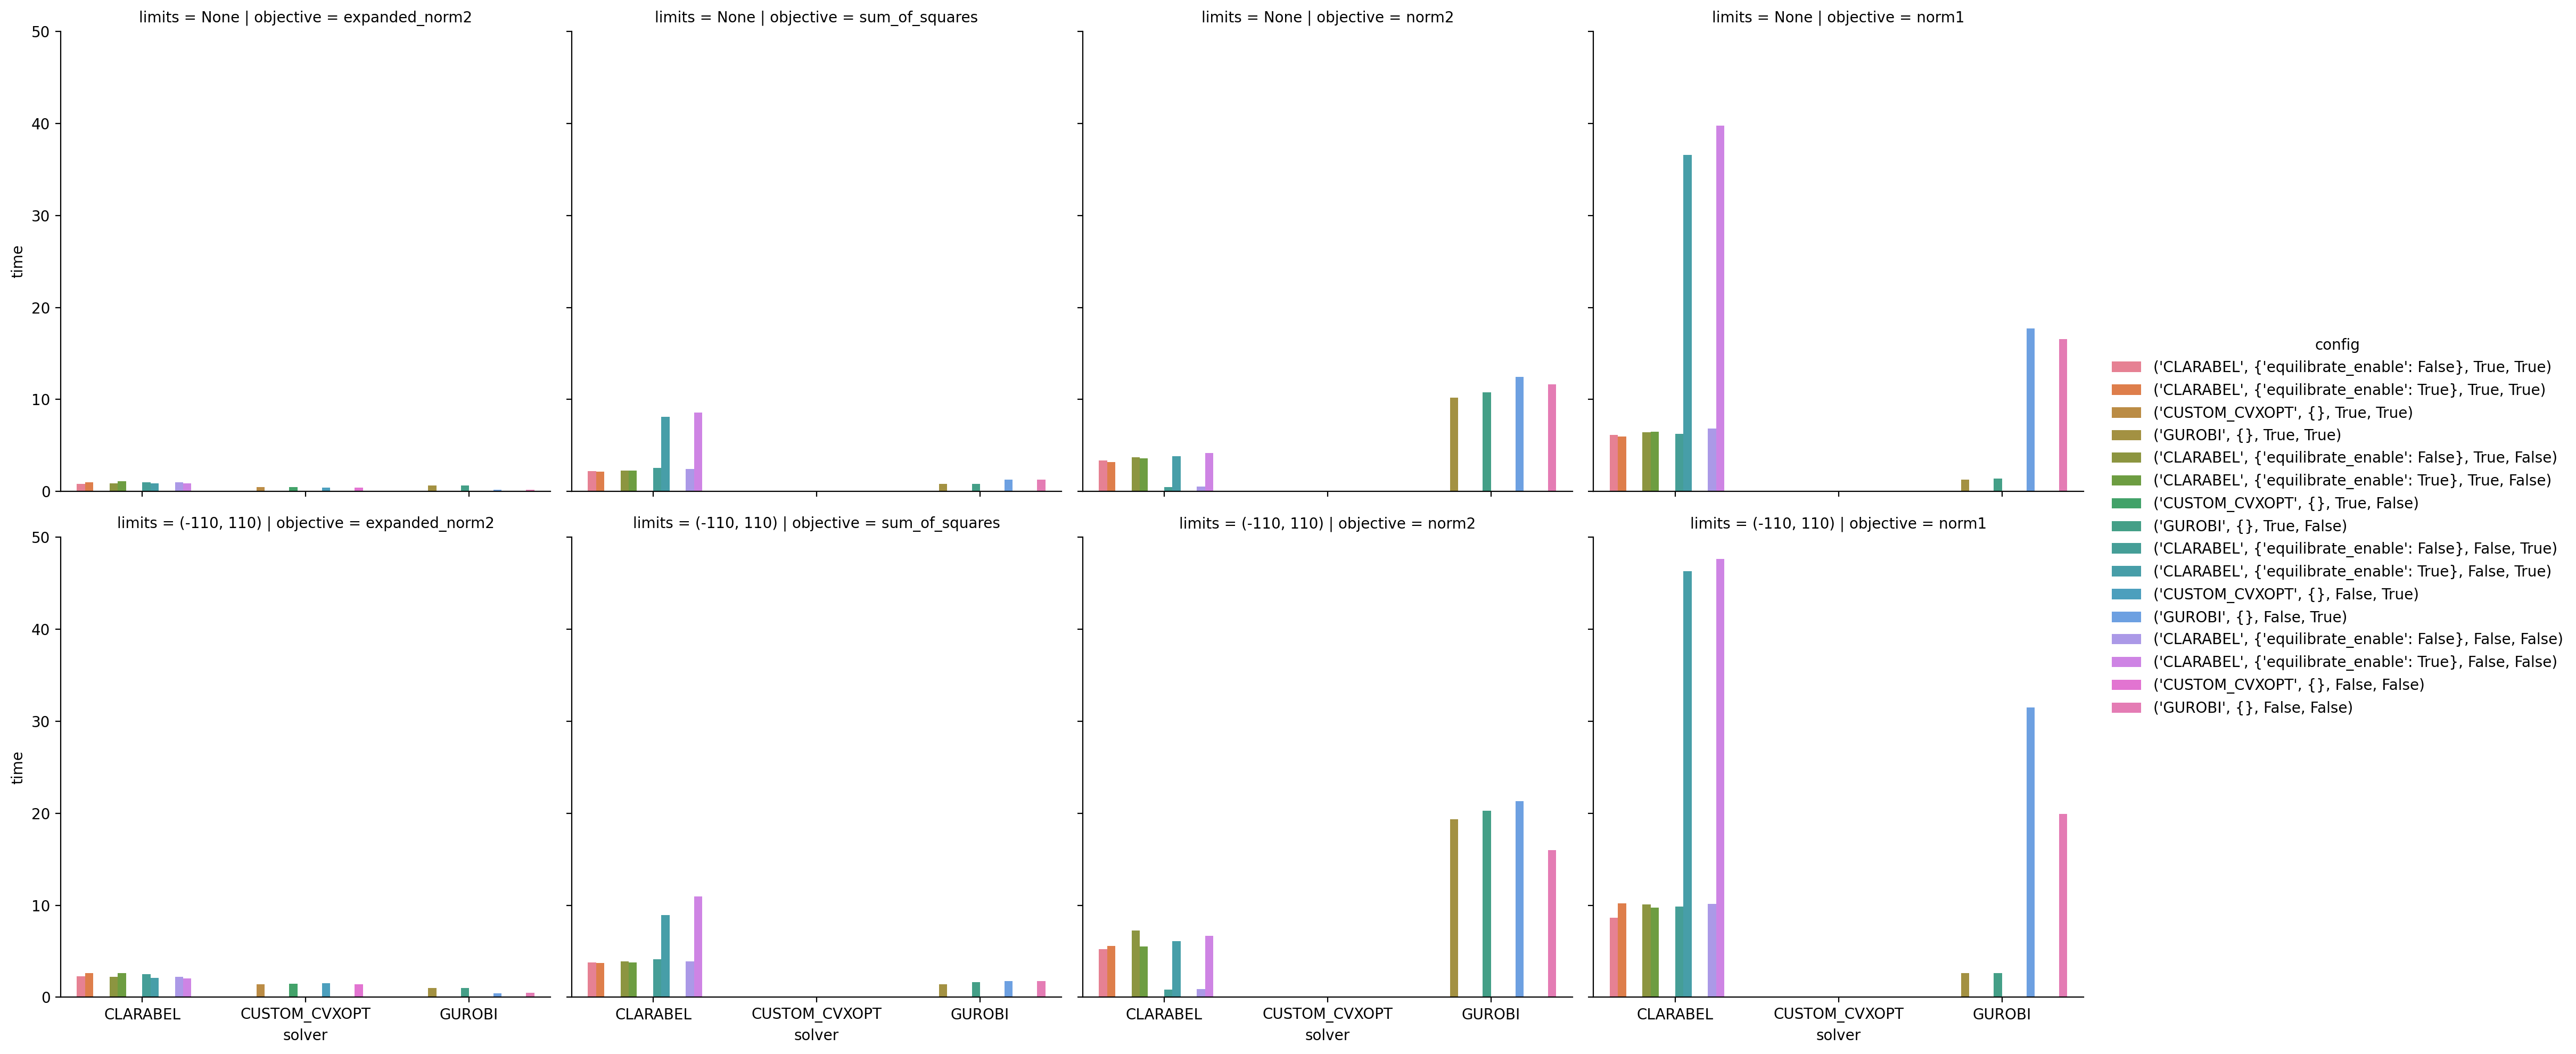

In [6]:
sns.catplot(
    data=df.assign(limits=lambda x: x.limits.astype(str)).query("dataset == 'japan'"),
    y="time",
    x="solver",
    row="limits",
    hue="config",
    col="objective",
    kind="bar",
)

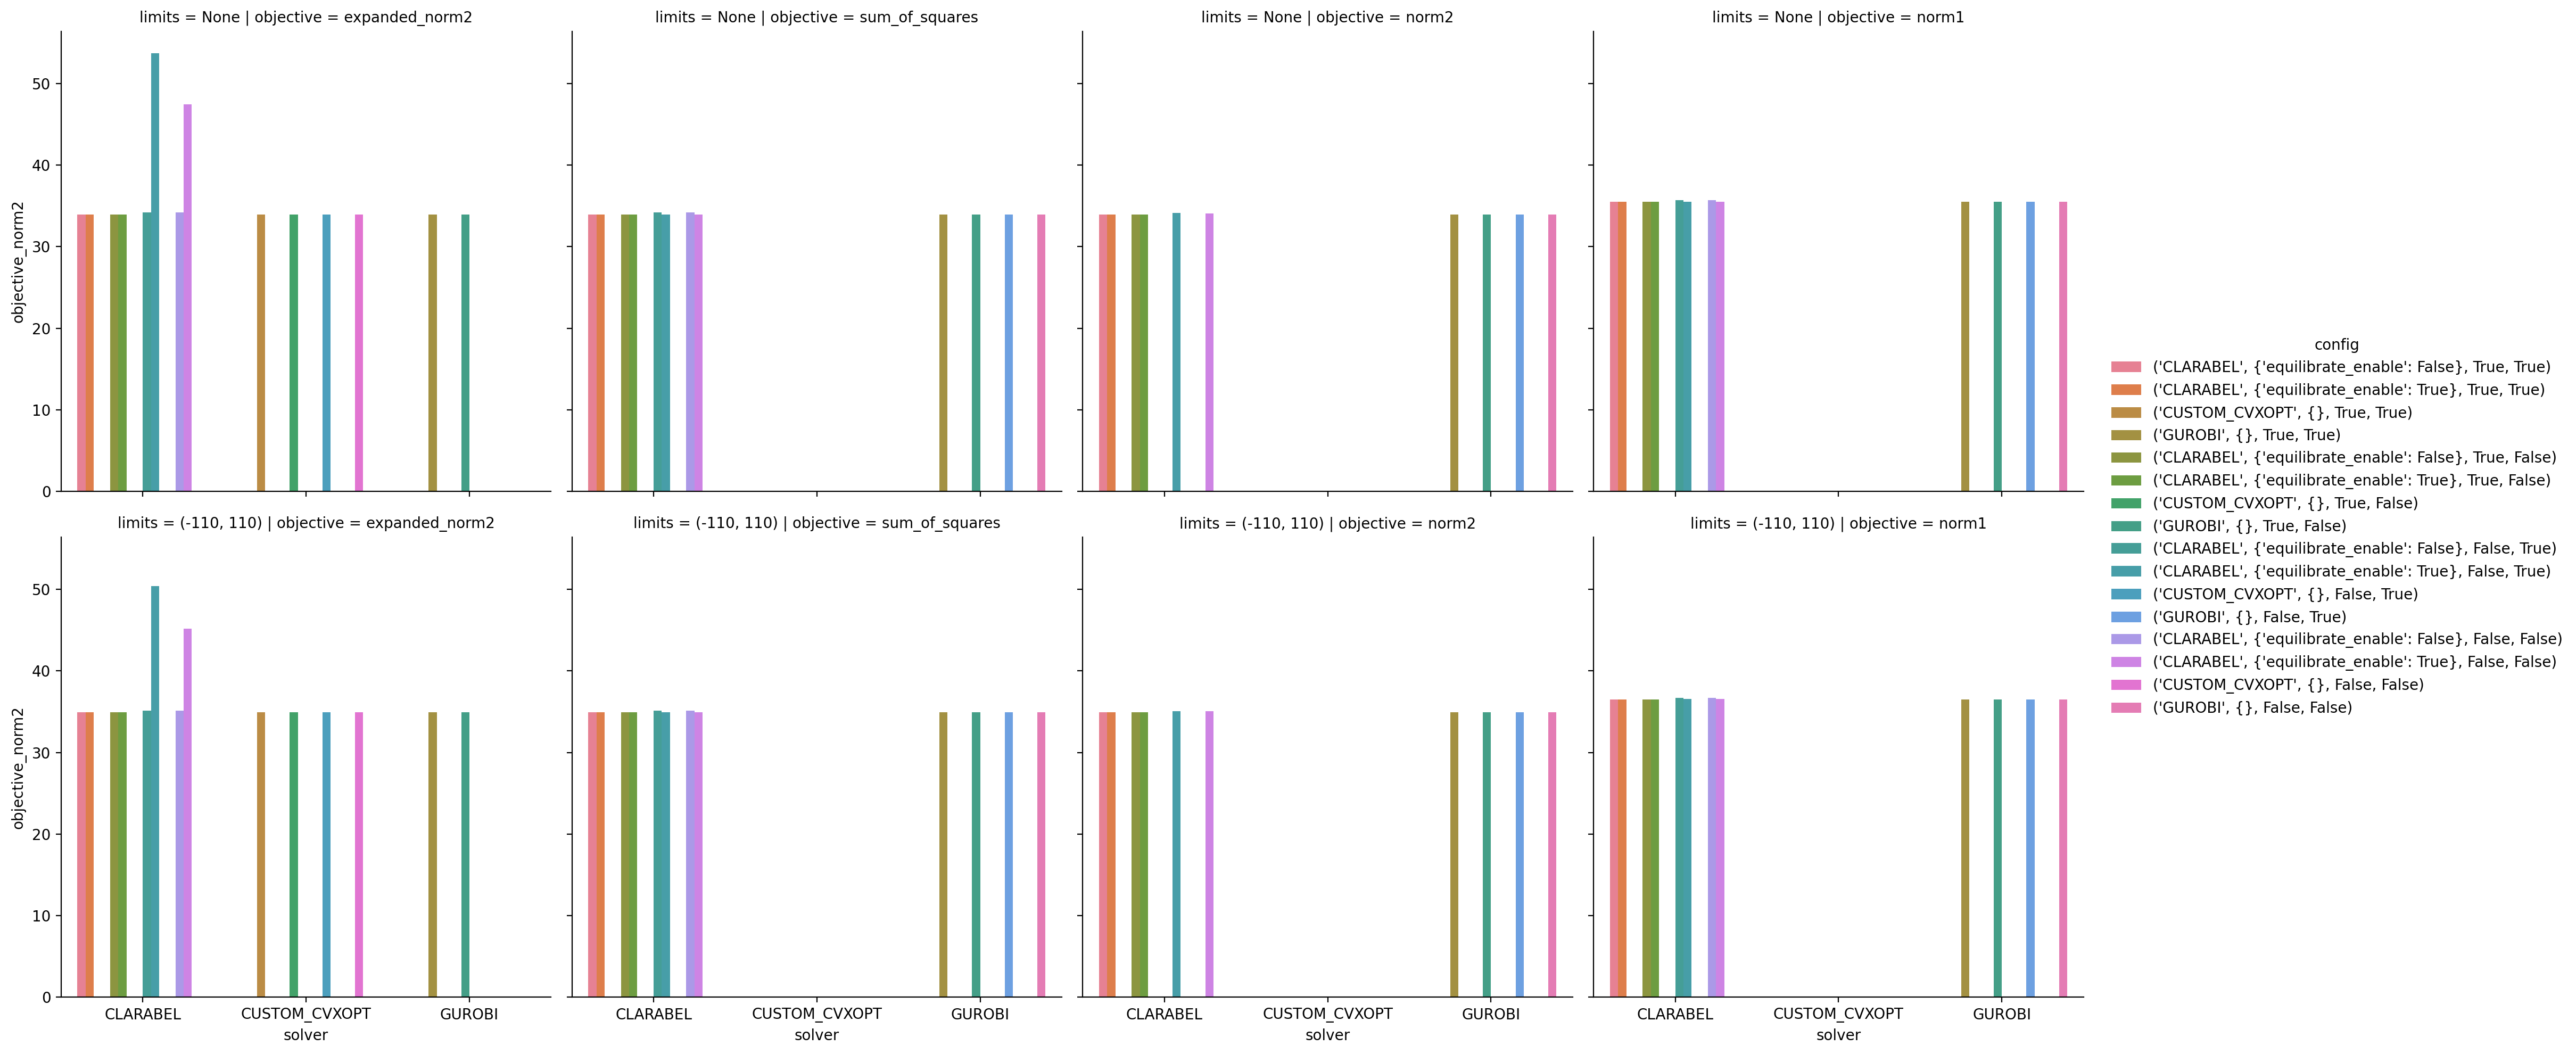

In [7]:
sns.catplot(
    data=df.assign(limits=lambda x: x.limits.astype(str)).query("dataset == 'japan'"),
    y="objective_norm2",
    x="solver",
    row="limits",
    hue="config",
    col="objective",
    kind="bar",
)

## North America

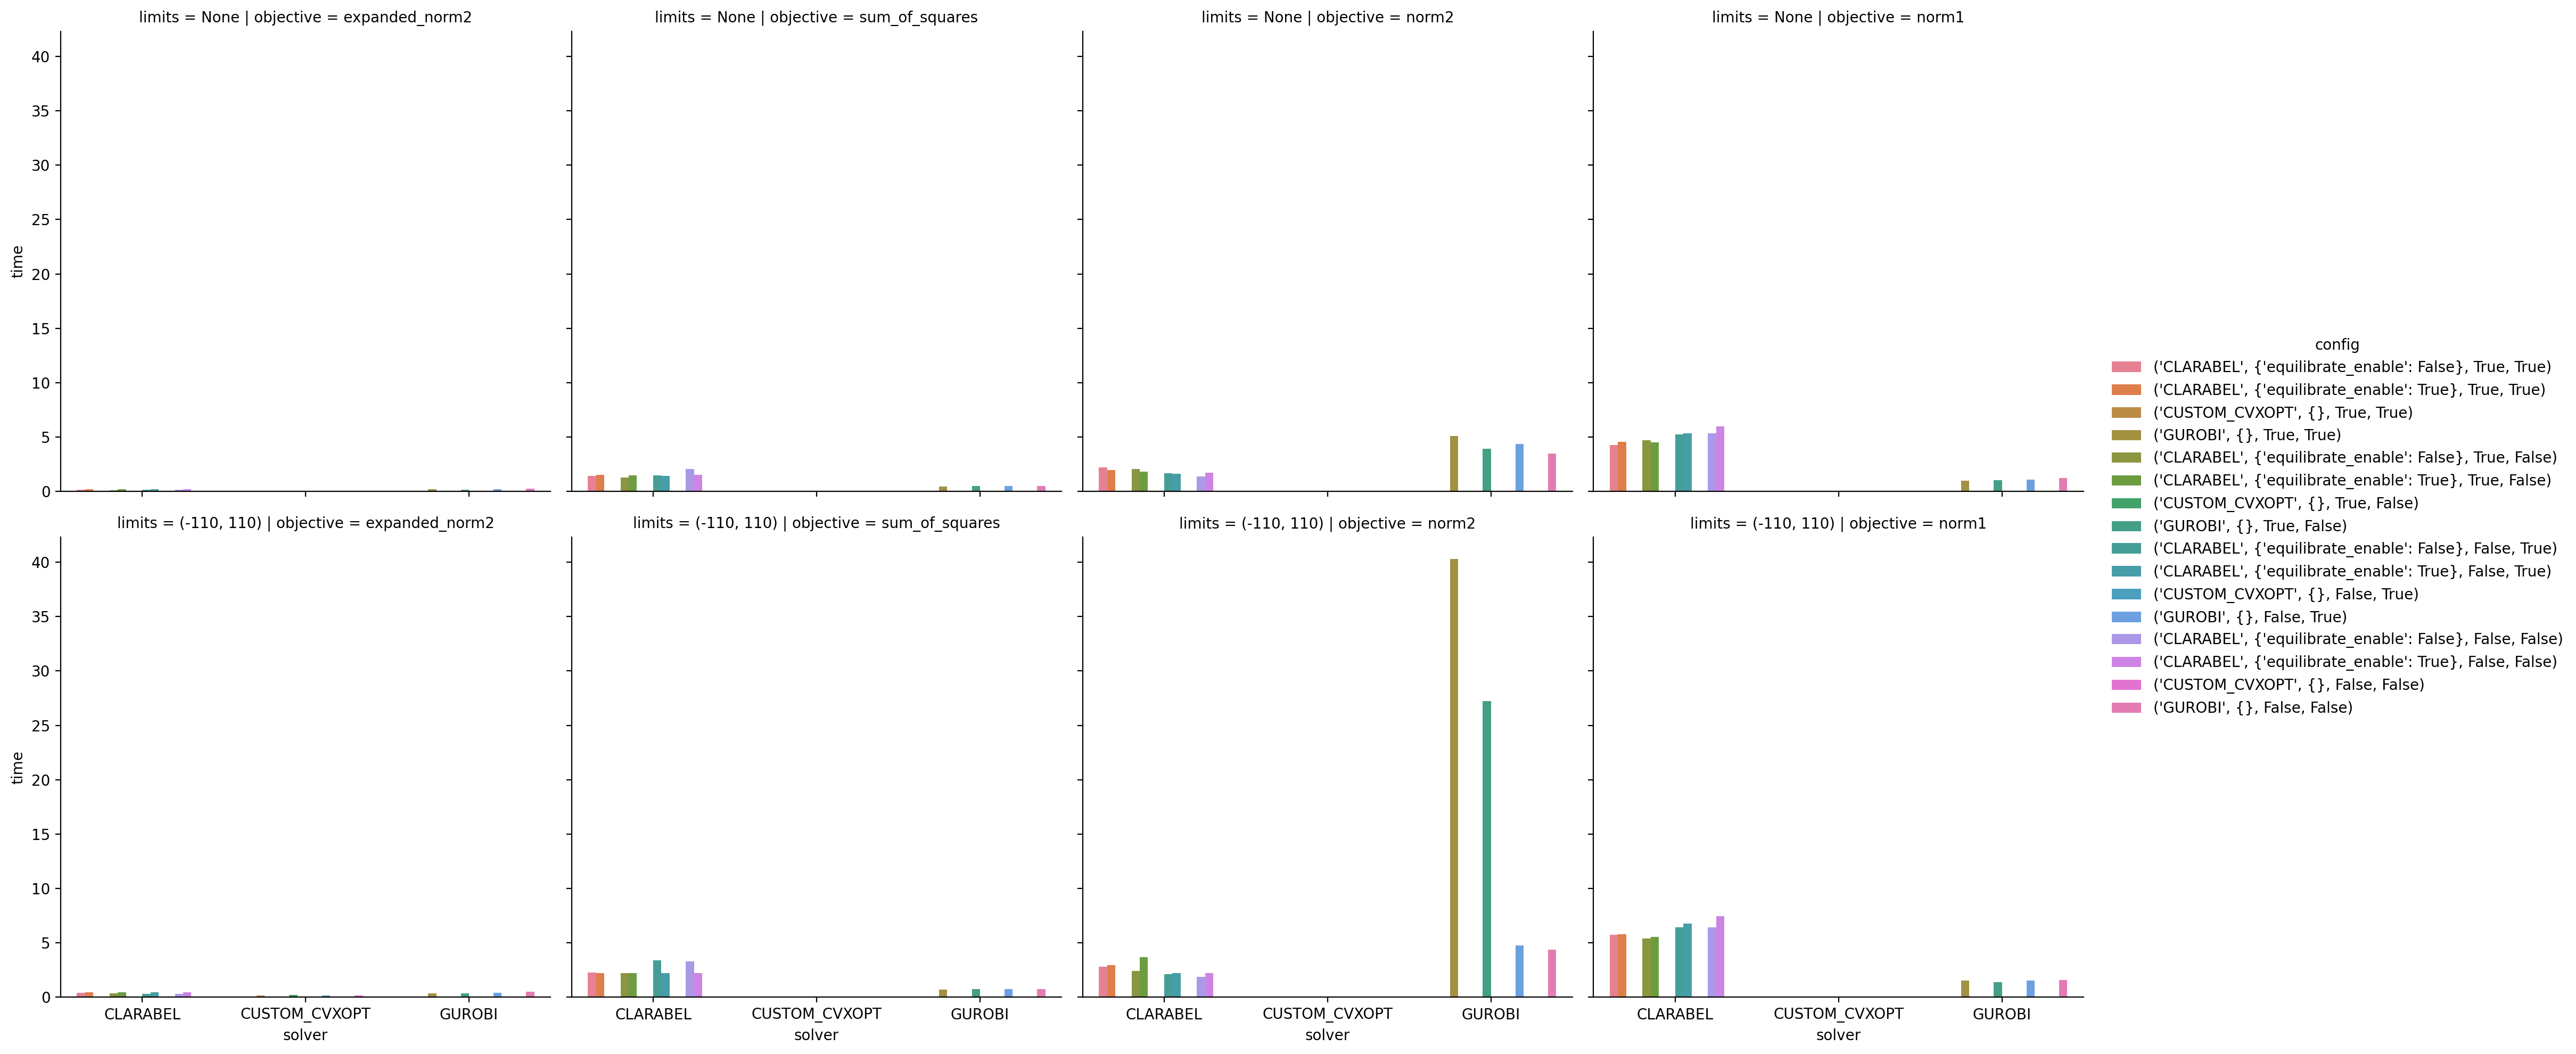

In [8]:
sns.catplot(
    data=df.assign(limits=lambda x: x.limits.astype(str)).query(
        "dataset == 'north_america'"
    ),
    y="time",
    x="solver",
    row="limits",
    hue="config",
    col="objective",
    kind="bar",
)

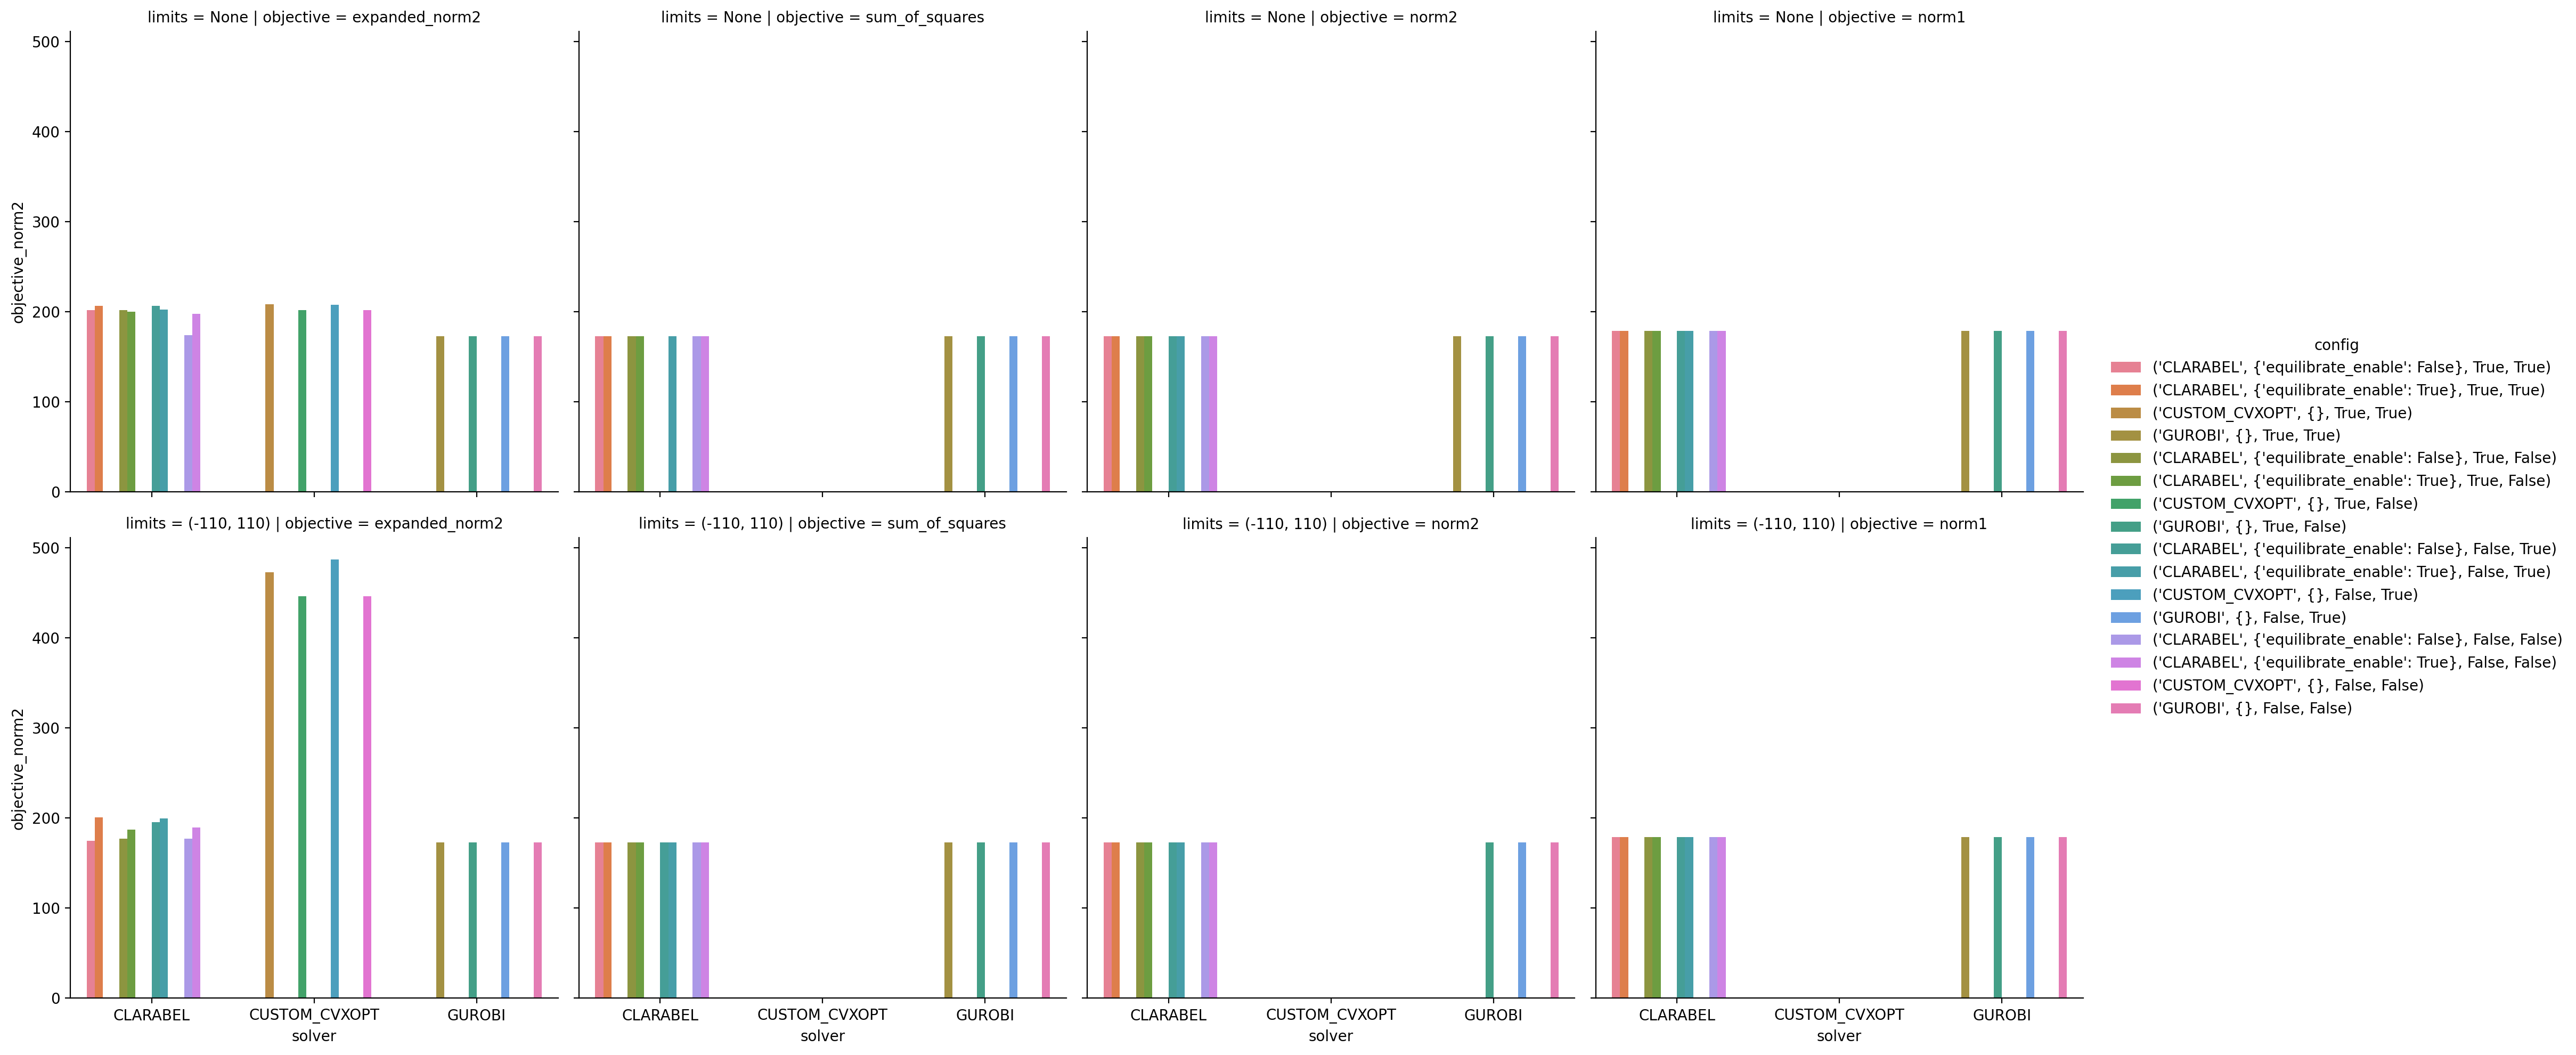

In [9]:
sns.catplot(
    data=df.assign(limits=lambda x: x.limits.astype(str)).query(
        "dataset == 'north_america'"
    ),
    y="objective_norm2",
    x="solver",
    row="limits",
    hue="config",
    col="objective",
    kind="bar",
)

## Run full optimization

In [4]:
%%time
problem = celeri.optimize.build_problem(command_files["japan"])

solve_kwargs = dict(
    solver="CLARABEL",
    equilibrate_enable=False,
    # direct_solve_method="faer",
    presolve_enable=False,
    warm_start=True,
    ignore_dpp=False,
)

trace_japan = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="sum_of_squares",
)

/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:244: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


Iteration: 1
5132 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 4.21e+06
residual 2-norm: 3.49059e+01
Iteration took 7.28s

Iteration: 2
4187 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.08e+06
residual 2-norm: 3.73034e+01
Iteration took 4.16s

Iteration: 3
2179 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.52e+05
residual 2-norm: 3.99714e+01
Iteration took 3.91s

Iteration: 4
994 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.53e+04
residual 2-norm: 4.13373e+01
Iteration took 4.65s

Iteration: 5
409 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.44e+03
residual 2-norm: 4.20956e+01
Iteration took 4.44s

Iteration: 6
209 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.47e+02
residual 2-norm: 4.23114e+01
Iteration took 4.40s

Iteration: 7
99 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.80e+01
residual 2-norm: 4.24715e+01
Iteration took 4.73s

Iter

In [11]:
%%time
problem = celeri.optimize.build_problem(command_files["japan"])

solve_kwargs = dict(
    solver="GUROBI",
    ignore_dpp=True,
)

trace = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="sum_of_squares",
)





Iteration: 1
5132 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 4.21e+06
residual 2-norm: 3.49059e+01
Iteration took 1.41s

Iteration: 2
4187 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.08e+06
residual 2-norm: 3.73034e+01
Iteration took 1.68s

Iteration: 3
2179 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.52e+05
residual 2-norm: 3.99714e+01
Iteration took 1.77s

Iteration: 4
994 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.53e+04
residual 2-norm: 4.13373e+01
Iteration took 1.90s

Iteration: 5
409 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.44e+03
residual 2-norm: 4.20956e+01
Iteration took 1.86s

Iteration: 6
209 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.47e+02
residual 2-norm: 4.23114e+01
Iteration took 1.87s

Iteration: 7
99 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.80e+01
residual 2-norm: 4.24715e+01
Iteration took 1.81s



In [10]:
%%time
problem = celeri.optimize.build_problem(command_files["japan"])

solve_kwargs = dict(
    solver="CUSTOM_CVXOPT",
    ignore_dpp=False,
)

trace = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="expanded_norm2",
)

/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:244: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


ValueError: Only 'ignore_dpp' is allowed as a keyword argument.

In [12]:
%%time
problem = celeri.optimize.build_problem(command_files["north_america"])

solve_kwargs = dict(
    solver="CLARABEL",
    equilibrate_enable=False,
    # direct_solve_method="faer",
    presolve_enable=False,
    warm_start=True,
    ignore_dpp=False,
)

trace_north_america = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="sum_of_squares",
)

Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:03<00:00, 483.72it/s]
/Users/meade/mambaforge/envs/celeri/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:244: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


Iteration: 1
1557 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 2.56e+05
residual 2-norm: 1.72765e+02
Iteration took 3.49s

Iteration: 2
1434 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.38e+05
residual 2-norm: 1.72836e+02
Iteration took 2.35s

Iteration: 3
987 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 2.32e+04
residual 2-norm: 1.75413e+02
Iteration took 3.62s

Iteration: 4
365 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 3.96e+03
residual 2-norm: 1.80627e+02
Iteration took 4.00s

Iteration: 5
52 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.24e+02
residual 2-norm: 1.83704e+02
Iteration took 3.82s

Iteration: 6
22 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.13e+01
residual 2-norm: 1.84521e+02
Iteration took 4.44s

Iteration: 7
11 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.81e+00
residual 2-norm: 1.84680e+02
Iteration took 4.80s

Iterati

In [13]:
%%time
problem = celeri.optimize.build_problem(command_files["north_america"])

solve_kwargs = dict(
    solver="GUROBI",
    ignore_dpp=True,
)

trace = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="sum_of_squares",
)

Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:03<00:00, 468.54it/s]


Iteration: 1
1557 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 2.56e+05
residual 2-norm: 1.72765e+02
Iteration took 0.69s

Iteration: 2
1434 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.38e+05
residual 2-norm: 1.72836e+02
Iteration took 0.72s

Iteration: 3
987 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 2.32e+04
residual 2-norm: 1.75413e+02
Iteration took 1.01s

Iteration: 4
365 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 3.96e+03
residual 2-norm: 1.80627e+02
Iteration took 0.98s

Iteration: 5
52 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.24e+02
residual 2-norm: 1.83704e+02
Iteration took 0.88s

Iteration: 6
22 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.13e+01
residual 2-norm: 1.84521e+02
Iteration took 0.93s

Iteration: 7
11 of 3682 velocities are out-of-bounds
Non-convex constraint loss: 1.81e+00
residual 2-norm: 1.84680e+02
Iteration took 0.94s

Iterati